# Objective:
The objective of this notebook is to split rasaif data to 3 splits(train,dev,test) .to enusre that splits have the same distribution, each book was splitted independentlly.  
- Before splitting any mislabeled record should be dropped.  
- After splitting need to check data leakage between the splits .

In [86]:
import huggingface_hub

In [1]:
huggingface_hub.login(token = "####################")

In [88]:
from datasets import load_dataset
from datasketch.minhash import MinHash
import re
import math
import pandas as pd
import tqdm
from sklearn.metrics import jaccard_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.seed = 1

In [4]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [5]:
# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("Rasaif/78k_AUG_2023_csv")

Repo card metadata block was not found. Setting CardData to empty.


In [6]:
df = dataset["train"].to_pandas()

# 1- Data Exploration 

In [7]:
df[:15]

,eng_Latn,arb_Arab,books
0,The History of al-Tabari,تاريخ الطبري,تاريخ_الطبري
1,Volume I,الجزء الأول,تاريخ_الطبري
2,"In the Name of God, the Merciful, the Compassi...",بسم الله الرحمن الرحيم,تاريخ_الطبري
3,"PRAISED BE GOD, first before any first and las...",الحمد لله الأول قبل كل أول، والآخر بعد كل آخر،...,تاريخ_الطبري
4,He is singular and unique without number. He r...,فهو الفرد الواحد من غير عدد، وهو الباقي بعد كل...,تاريخ_الطبري
5,"His are glory and greatness, splendor and migh...",له الكبرياء والعظمة، والبهاء والعزة، والسلطان ...,تاريخ_الطبري
6,"He is above having a partner in His authority,...",تعالى عن أن يكون له شريك في سلطانه أو في وحدان...,تاريخ_الطبري
7,He cannot be fully imagined and encompassed by...,لا تحيط به الأوهام، ولا تحويه الأقطار، ولا تدر...,تاريخ_الطبري
8,I praise Him for His benefits and am grateful ...,أحمده على آلائه، وأشكره على نعمائه، حمد من أفر...,تاريخ_الطبري
9,I ask Him to grant me to say and do what will ...,وأستهديه من القول والعمل لما يقربني منه ويرضيه...,تاريخ_الطبري


In [8]:
def english(text):
    return len(re.findall("[a-z]+",text)) > 0

def arabic(text):
     return len(re.findall("[ء-ي]+",text)) > 0

In [9]:
df[df["arb_Arab"].map(english) ]

,eng_Latn,arb_Arab,books
43303,"(7)The standard of Mushgir has come to us, Whi...",blood).2°3//,تاريخ_الطبري
43503,Then there is the fact that the Messenger of G...,// al-Hakam b. Abi al-‘As because he imitated ...,تاريخ_الطبري
45937,"Then God raised him up, saying, ""How long have...",ثم بعثه الله فقال له: «كم لبثت قال لبثت يوما أ...,تاريخ_الطبري


In [10]:
df[df["arb_Arab"].map(lambda x: "سقطمن" in x )]

,eng_Latn,arb_Arab,books
16756,40The Victory of the Marwanids,سقطمنالنص,تاريخ_الطبري
17172,[Those in Office during the Year],سقطمنالنص,تاريخ_الطبري
46693,Excerpts from The Supplement to the Supplement...,سقطمنالترجمة,تاريخ_الطبري


In [11]:
df[df["arb_Arab"].map(lambda x: "سقط من" in x )]

,eng_Latn,arb_Arab,books
429,They praise God that He gave them the power to...,فيحمدون الله على ما قواهم لذلك، ويتعلقون بعرا ...,تاريخ_الطبري
5548,"Before they could get up, a magpie landed on t...",فما قاموا حتى وقع على الشرفات عقعق، فسقط منه ا...,تاريخ_الطبري
10709,"When I came upon them, they sprang up and a da...",وهم نجي، فلما رهقتهم ثاروا، وسقط منهم خنجر له ...,تاريخ_الطبري
11426,"He said: ""They will not give up their position...",[فقال: إن هؤلاء لن يزولوا عن موقفهم دون طعن در...,تاريخ_الطبري
12126,The people feared his government greatly so th...,وخافه الناس في سلطانه خوفا شديدا، حتى أمن النا...,تاريخ_الطبري
15041,"Muslim b. 'Awsajah said, ""May I offer my soul ...",فقال له مسلم بن عوسجة: يا بن رسول الله، جعلت ف...,تاريخ_الطبري
15282,According to Abu Mikhnaf—Fudayl Khadij al-Kind...,قال أبو مخنف: حدثني فضيل بن خديج الكندي أن يزي...,تاريخ_الطبري
15283,"Al-Husayn would say, ""O God! Make his aim be s...",ويقول حسين: [اللهم سدد رميته، واجعل ثوابه الجن...,تاريخ_الطبري
16165,According to al-Muthanna—Abu Hudhayfah—Shibl—I...,حدثني المثنى، قال: حدثنا أبو حذيفة، قال: حدثنا...,تاريخ_الطبري
18448,"The Muhallabids, together with the runaway sol...",ومضى آل المهلب ومن سقط منهم من الفلول حتى انته...,تاريخ_الطبري


In [12]:
df[df["eng_Latn"].map(arabic) ]

,eng_Latn,arb_Arab,books
2442,‘Alه b. Abi Talib bought the daughter of Rabi‘...,فاشترى علي بن ابى طالب ع بنت ربيعه ابن بجير ال...,تاريخ_الطبري
11342,سقطمنالنص,والله لو ضربونا حتى يبلغوا بنا سعفات هجر لعلمن...,تاريخ_الطبري
17201,سقطمنالنص,ذكر امر الكرسي الذى كان المختار يستنصر به!,تاريخ_الطبري
21545,سقطمنالنسخ,قال:كنت أمس أحسن حالا مني اليوم قال: وكيف ذاك؟,تاريخ_الطبري
26442,سقطمنالمنسخة,قدوم قحطبه بن شبيب على ابى مسلم,تاريخ_الطبري
43193,Wasif listened to them and left.\tفاطاعهم ومض...,اللهم اصلح الداعي الى الحق،,تاريخ_الطبري
43440,so that those who perish perish on the basis o...,فاهتدى به من اهتدى، واستنقذ به من استجاب له من...,تاريخ_الطبري
43685,Abu Layla left the room and hid amid bedding ...,فاعتزلهم ابو ليلى والسيف في يده، وقال لهم: انا...,تاريخ_الطبري
44433,Those people came to us and slaughtered my fat...,والله ما ادرى ممن هو هذا الولد منهم!,تاريخ_الطبري
44540,"Glory to you, O God! Their greeting in Paradis...",وصلى الله على جدي محمد رسول الله.,تاريخ_الطبري


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78444 entries, 0 to 78443
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   eng_Latn  78444 non-null  object
 1   arb_Arab  78444 non-null  object
 2   books     78444 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [14]:
df.iloc[44971].arb_Arab

' وكان يقول: لا اخرج والمعتضد في الأحياء '

In [15]:
df.iloc[62240].eng_Latn

'Al-Hasan ibn Abه al-Hasan al-Basri was asked, “Why has poverty been associated with learning, and wealth with ignorance?” He answered, “What you said is not correct, for you have sought what is little among the few and so you could not find it. You have sought wealth, which is little, among the learned, who are a few; if you had looked for those who were poor among the ignorant, you would have found them to be more in number.”'

In [16]:
# Founded manually using queries described above
rows_to_drop = [43303,43503,16756,17172,46693,67355,67356,11342,17201,21545,26442,44971,44788,44540,44433,43685,43440,43193]
df = df[~df.index.isin(rows_to_drop)]

In [17]:
df.groupby("books").count().sort_values("eng_Latn")

,eng_Latn,arb_Arab
books,,
حي,454,454
الغرباء,538,538
رسالة_الشافعي,2070,2070
النوادر_السلطانية,4183,4183
العقد_الفريد,5505,5505
القرآن_يوسف,6234,6234
الأخلاق_والسير,8994,8994
تاريخ_الطبري,50448,50448


# 2- Data Splitting

In [18]:
def get_sample(df, sample_by_col,max_num_samples = 1000,sampleing_ratio_per_book = .2):
    return(
        df
        .groupby(sample_by_col)
        .apply(
            lambda x: x.sample(min(max_num_samples, math.ceil(len(x)* sampleing_ratio_per_book)))
        )
        .reset_index(drop=True)
    )

In [19]:
df["mapping_id"] = df.index
test_dev = get_sample(df,"books",max_num_samples = 2000, sampleing_ratio_per_book = .35)
train = df[~df.mapping_id.isin(test_dev.mapping_id)]
dev =  get_sample(test_dev,"books",max_num_samples = 1500, sampleing_ratio_per_book = .50)
test = test_dev[~test_dev.mapping_id.isin(dev.mapping_id)]

In [20]:
dev

,eng_Latn,arb_Arab,books,mapping_id
0,A group of astrologers and diviners informed h...,وأعلمه قوم من المنجمين والعرافين صلاح مولده، و...,الأخلاق_والسير,51500
1,"When Dhu Yazan went up to the emperor, the lat...",فأقبل عليه، فألطفه وأحسن مسألته، وقال له: ما ا...,الأخلاق_والسير,53173
2,'Ubaydallah b. Said [al-Zuhri]—his uncle [Ya'q...,حدثنا عبيد الله بن سعد، قال: أخبرنا عمي، قال: ...,الأخلاق_والسير,56466
3,"'Adi b. Hatim: She came to me and said, ""You h...",فقالت: لقد فعلت فعلة ما كان أبوك يفعلها!,الأخلاق_والسير,55362
4,Upon the king's order he was thrown on the gro...,فأمر فبطح في السجن على وجهه، ثم أوتد في يديه و...,الأخلاق_والسير,51250
...,...,...,...,...
5230,God also said: «And know that a fifth of whate...,"قال الله: "" واعلموا أنما غنمتم من شيء فأن لله ...",رسالة_الشافعي,70442
5231,"Mālik reported to us from Nāfiʿ, from Ibn ʿUma...","أخبرنا ""مالك"" عن ""نافع"" عن ""ابن عمر""، أراه عن ...",رسالة_الشافعي,70754
5232,"So, I continued, his resolve not to return has...",قلت: ولا يصنع عزمه على ألا يفيء؟ ولا يمنعه جما...,رسالة_الشافعي,72098
5233,and «And signs. And men can guide themselves b...,وقال: (وعلامات وبالنجم هم يهتدون) (النحل 16),رسالة_الشافعي,70227


In [69]:
len(train),len(dev),len(test),

(67961, 5235, 5230)

In [21]:
def fix_rtl(df,col):
    df[col+"_ltr"] = df[col].map(lambda x: "".join([x[i] for i in reversed(range(len(x)))]))
    return df

/tmp/ipykernel_22161/3870329260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col+"_ltr"] = df[col].map(lambda x: "".join([x[i] for i in reversed(range(len(x)))]))
/tmp/ipykernel_22161/3870329260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col+"_ltr"] = df[col].map(lambda x: "".join([x[i] for i in reversed(range(len(x)))]))


<Axes: xlabel='books_ltr'>

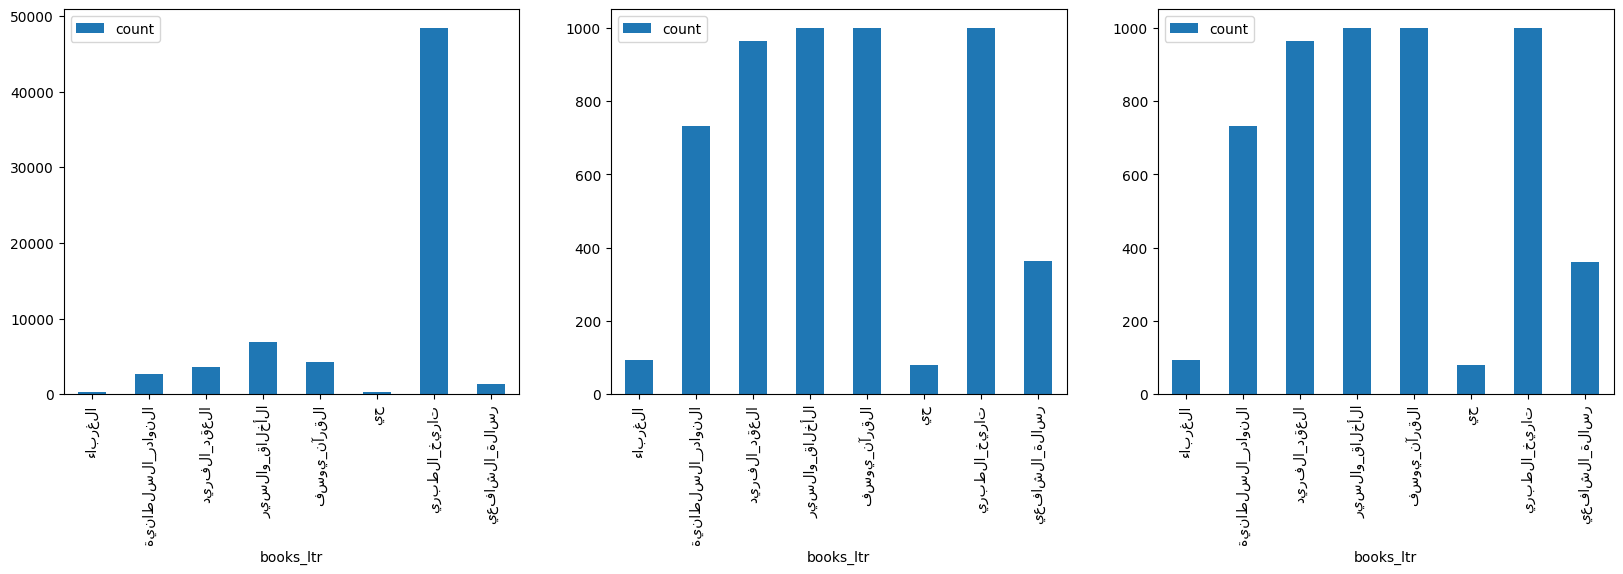

In [22]:
fig ,ax = plt.subplots(ncols=3,figsize = (20,5))

(
    train
    .pipe(fix_rtl,"books")
    .groupby("books_ltr")
     .agg(count = ("eng_Latn","count"))
    .plot.bar(ax = ax[0])
)

(
    dev
    .pipe(fix_rtl,"books")
    .groupby("books_ltr")
     .agg(count = ("eng_Latn","count"))
    .plot.bar(ax = ax[1])
)

(
    test
    .pipe(fix_rtl,"books")
    .groupby("books_ltr")
     .agg(count = ("eng_Latn","count"))
    .plot.bar(ax = ax[2])
)

<Axes: >

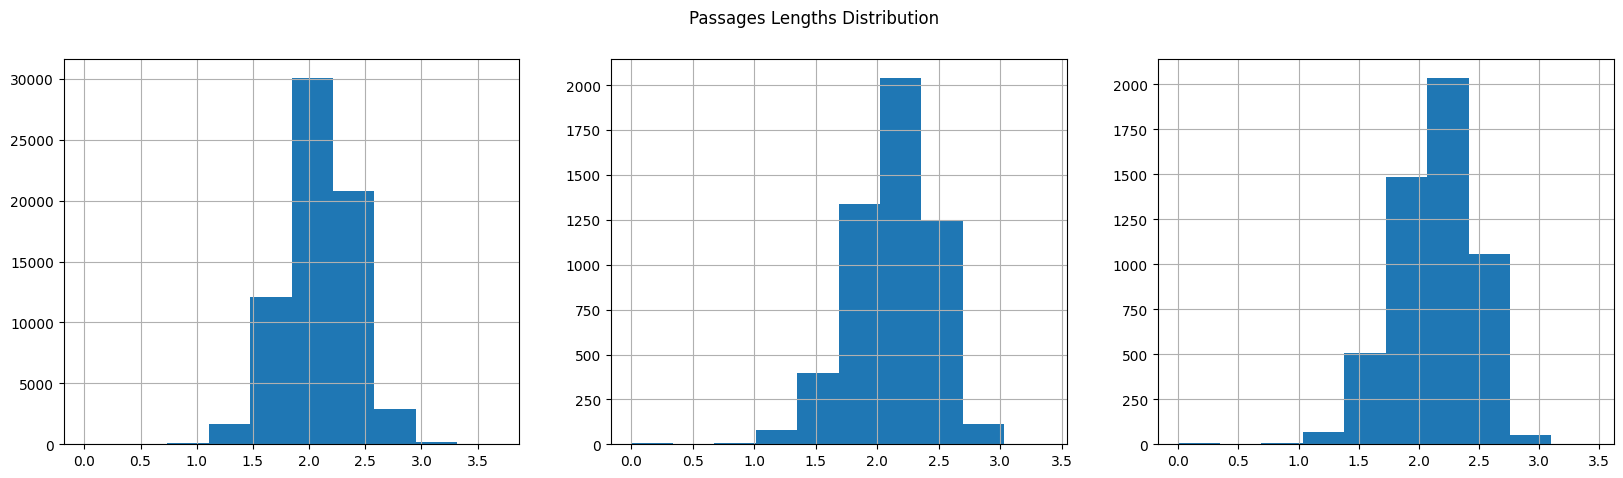

In [23]:
fig ,ax = plt.subplots(ncols=3,figsize = (20,5))
fig.suptitle('Passages Lengths Distribution')
(
    train
    .eng_Latn
    .map(len)
    .map(np.log10)
    .hist(ax = ax[0])
)

(
    dev
    .eng_Latn
    .map(len)
    .map(np.log10)
    .hist(ax = ax[1])
)

(
    test
    .eng_Latn
    .map(len)
    .map(np.log10)
    .hist(ax = ax[2])
)

In [24]:
display_side_by_side(
    train.groupby("books").agg(count = ("eng_Latn","count")).sort_values("count"),
    dev.groupby("books").agg(count = ("eng_Latn","count")).sort_values("count"),
    test.groupby("books").agg(count = ("eng_Latn","count")).sort_values("count"),
)

,count
books,
حي,295
الغرباء,349
رسالة_الشافعي,1345
النوادر_السلطانية,2718
العقد_الفريد,3578
القرآن_يوسف,4234
الأخلاق_والسير,6994
تاريخ_الطبري,48448
,count


# 3- Checking similarity between splits (leakage detecting)

In [25]:
def get_hash(text):
    m = MinHash()
    for word in text.split():
        m.update(word.encode('utf8'))
    return m.hashvalues

In [26]:
dev_minhashs = np.array(dev.eng_Latn.map(get_hash).tolist())
test_minhashs = np.array(test.eng_Latn.map(get_hash).tolist())
train_minhashs = np.array(train.eng_Latn.map(get_hash).tolist())

### Test and Trian

In [27]:
# Test and Trian
jaccard_similarity_scores_test_train = np.count_nonzero(test_minhashs[:][None,:,:] == train_minhashs[:][:,None,:],axis=-1)/train_minhashs.shape[1]

In [28]:
jaccard_similarity_scores_test_train.shape

(67961, 5230)

In [63]:
print("how many passages has > .69 similarity score?")
len(np.unique(np.where(jaccard_similarity_scores_test_train.T >.69)[0]))/jaccard_similarity_scores_test_train.T.shape[0]

how many passages has > .69 similarity score?


0.011089866156787764

In [30]:
print("how many identical passages (i.e. > .99)?")
len(np.unique(np.where(jaccard_similarity_scores_test_train.T >.99)[0]))/jaccard_similarity_scores_test_train.T.shape[0]

how many identical passages (i.e. > .99)?


0.005353728489483747

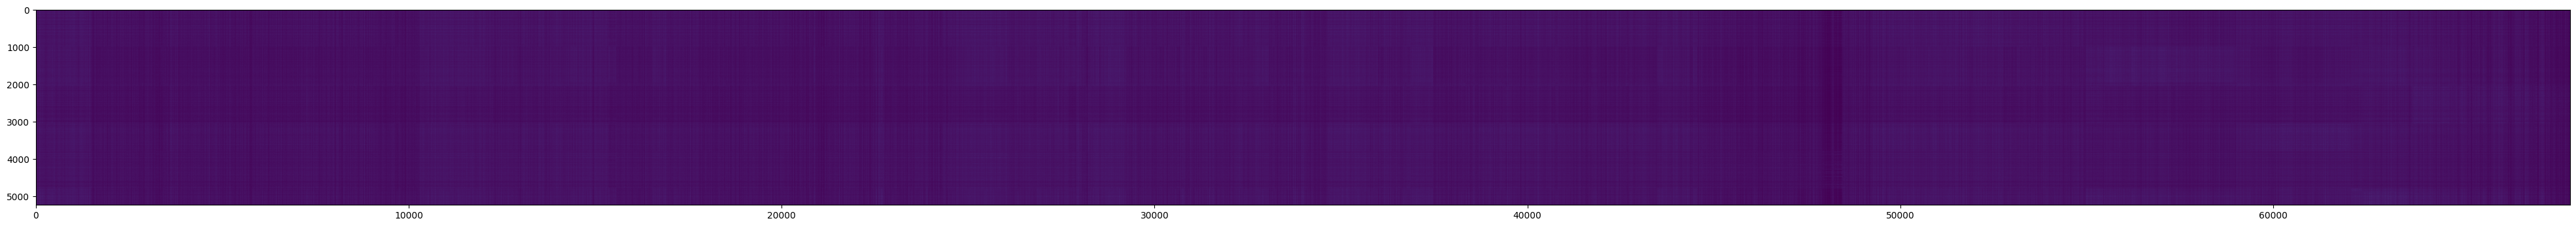

In [31]:
plt.figure(figsize=(50,10))
plt.imshow(jaccard_similarity_scores_test_train.T, cmap='viridis')
# plt.colorbar()
plt.show()

In [32]:
np.where(np.array([[1,2,7,4,5],[9,2,3,4,5]]) >6)[1]

array([2, 0])

In [99]:
np.where(np.array([[[1,2,7,4,5],[9,2,3,4,5]]]) >6)

(array([0, 0]), array([0, 1]), array([2, 0]))

In [60]:
train.iloc[52547]

eng_Latn      In this year, the deputation of al-Rahawiyyun ...
arb_Arab                               وفيها قدم وفد الرهاويين.
books                                            الأخلاق_والسير
mapping_id                                                55726
books_ltr                                        ريسلاو_قالخألا
Name: 55726, dtype: object

In [44]:
test.iloc[62]

eng_Latn      In this year, the deputation of 'Abs came.
arb_Arab                         قال: وفيها قدم وفد عبس.
books                                     الأخلاق_والسير
mapping_id                                         55728
books_ltr                                 ريسلاو_قالخألا
Name: 117, dtype: object

In [57]:
jaccard_similarity_scores_test_train.T[jaccard_similarity_scores_test_train.T >.65]

array([0.6640625, 0.65625  , 0.671875 , 0.75     , 0.6953125, 0.7109375,
       0.8828125, 0.703125 , 0.6953125, 0.6875   , 0.71875  , 0.6875   ,
       0.6640625, 0.671875 , 0.7265625, 0.7265625, 0.7265625, 0.7265625,
       0.7265625, 0.7265625, 0.7265625, 1.       , 1.       , 1.       ,
       1.       , 0.78125  , 1.       , 1.       , 1.       , 1.       ,
       1.       , 0.6875   , 1.       , 0.7734375, 0.6796875, 0.9453125,
       1.       , 1.       , 1.       , 1.       , 1.       , 0.8125   ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       0.796875 , 1.       , 0.8984375, 0.828125 , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 0.671875 , 0.78125  , 0.78125  , 0.78125  ,
       0.6875   , 0.7421875, 0.671875 , 1.       , 1.       , 1.       ,
       0.8828125, 0.8828125, 0.7578125, 0.8828125, 

In [59]:
np.where(jaccard_similarity_scores_test_train.T >.65)[1]

array([52369, 52394, 52518, 52547, 52551, 49979, 49436, 48898, 52057,
       45423, 49354, 52994, 47157, 47684,  1490,  1947,  2012,  2030,
        2065,  2071,  2085,  8335,  8347,  8361,  8373,  8389,  8429,
        8473,  8489,  8599,  8610, 52445, 53934, 52463, 53402, 57929,
       66705, 66768, 65724, 67539, 67543, 67547, 67551, 67554, 67556,
       67560, 67562, 67564, 65732, 66406, 66769, 65712, 65754, 65781,
       65802, 65820, 65843, 65733, 64373, 64838, 64995, 65023, 65299,
       65508, 66009, 66052, 66427, 66392, 66583, 66361, 66371, 66377,
       64964, 66379, 67681, 66993, 67010, 65814, 65794, 65806, 65824,
       65836, 64373, 64838, 64995, 65023, 65299, 65508, 66009, 66052,
       66427, 65711, 65780, 65791, 65819, 65842, 64689, 65488, 64373,
       64838, 64995, 65023, 65299, 65508, 66009, 66052, 66427, 64569,
       66183, 65793, 65805, 65724, 64712, 67143, 65793, 65796, 65805,
       65793, 65796, 65805, 66379, 66319, 67645, 65711, 65780, 65791,
       65819, 65842,

In [64]:
jaccard_similarity_scores_test_train[jaccard_similarity_scores_test_train >.6][38]

0.625

In [49]:
jaccard_similarity_scores_test_train[17979][4371]

0.7109375

In [69]:
train.iloc[7848][0]

'Their churches will not be inhabited [by Muslims] and will not be de-stroyed.'

In [70]:
test.iloc[4321][0]

'Their churches will not be inhabited [by the Muslims] and will not be destroyed.'

### Dev and Train

In [64]:
# Dev and Trian
jaccard_similarity_scores_dev_train = np.count_nonzero(dev_minhashs[:][None,:,:] == train_minhashs[:][:,None,:],axis=-1)/dev_minhashs.shape[1]

In [65]:
jaccard_similarity_scores_dev_train.shape

(67961, 5235)

In [66]:
print("how many passages has > .69 similarity score?")
len(np.unique(np.where(jaccard_similarity_scores_dev_train.T >.69)[0]))/jaccard_similarity_scores_dev_train.T.shape[0]

how many passages has > .69 similarity score?


0.013180515759312322

In [67]:
print("how many identical passages (i.e. > .99)")
len(np.unique(np.where(jaccard_similarity_scores_dev_train.T >.99)[0]))/jaccard_similarity_scores_dev_train.T.shape[0]

how many identical passages (i.e. > .99)


0.0057306590257879654

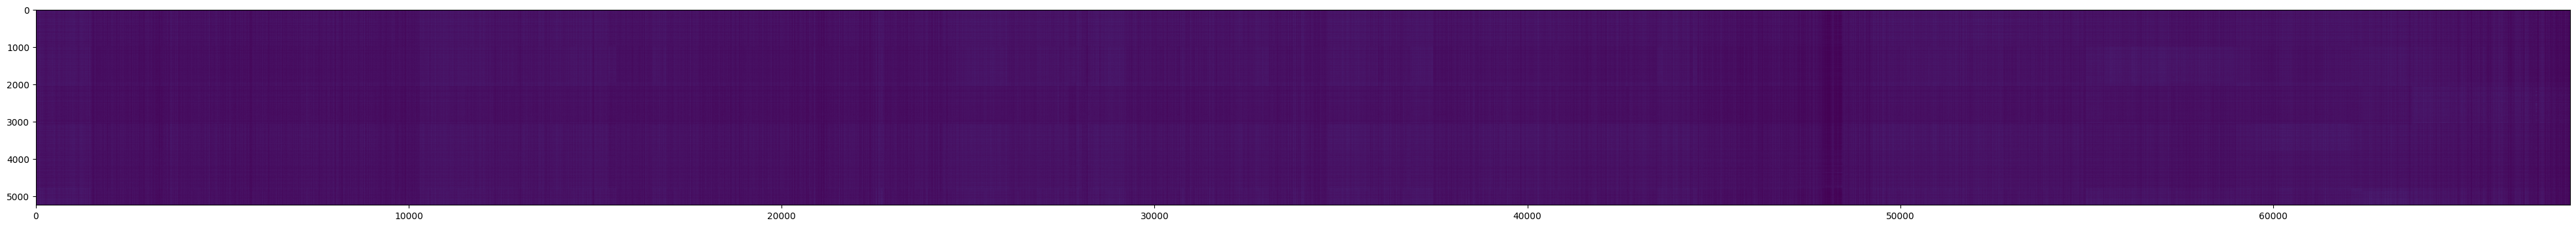

In [68]:
plt.figure(figsize=(50,10))
plt.imshow(jaccard_similarity_scores_dev_train.T, cmap='viridis')
# plt.colorbar()
plt.show()

In [151]:
 minhashs_numpy.shape[0]

78426

# 4- Data Uploading

In [75]:
new_datasets['test']

Dataset({
    features: ['eng_Latn', 'arb_Arab', 'books', '__index_level_0__'],
    num_rows: 5230
})

In [77]:
new_datasets

DatasetDict({
    train: Dataset({
        features: ['eng_Latn', 'arb_Arab', 'books'],
        num_rows: 67961
    })
    validation: Dataset({
        features: ['eng_Latn', 'arb_Arab', 'books'],
        num_rows: 5235
    })
    test: Dataset({
        features: ['eng_Latn', 'arb_Arab', 'books'],
        num_rows: 5230
    })
})

In [83]:
# from datasets import Dataset, DatasetDict



# new_datasets = DatasetDict()

# new_datasets['train'] = Dataset.from_pandas(train[["eng_Latn","arb_Arab","books"]],preserve_index=False)
# # .remove_columns(["__index_level_0__"])
# new_datasets['validation'] = Dataset.from_pandas(dev[["eng_Latn","arb_Arab","books"]],preserve_index=False)
# new_datasets['test'] = Dataset.from_pandas(test[["eng_Latn","arb_Arab","books"]],preserve_index=False)

# new_datasets.push_to_hub("Rasaif/78k_AUG_2023_csv_splited",private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/68 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

In [89]:
test_uploading = load_dataset("Rasaif/78k_AUG_2023_csv_splited")

In [100]:
pd.Series([len(i.split()) for i in test_uploading["train"]["arb_Arab"]]).describe()

count    67961.000000
mean        16.945881
std         14.802836
min          1.000000
25%          8.000000
50%         13.000000
75%         22.000000
max        528.000000
dtype: float64

In [101]:
 test_uploading["validation"]

Dataset({
    features: ['eng_Latn', 'arb_Arab', 'books'],
    num_rows: 5235
})

In [99]:
max([len(i.split()) for i in test_uploading["validation"]["arb_Arab"]])

264